In [14]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np 
import psycopg2


In [18]:
conn = psycopg2.connect(
    host="localhost",      # or "127.0.0.1"
    port=5432,
    dbname="BIChallange",
    user="postgres",
    password="***"
)

cur = conn.cursor()
cur.execute("""SELECT
                assigned_to,
                DATE_TRUNC('month', COALESCE(won_at, lost_at, open_at))::Date AS period,
                COUNT(*) AS total_cases,
                SUM(won_cases) AS wc,
                SUM(lost_cases) AS lc,
                SUM(open_cases) AS oc,
                ROUND(100.0 * SUM(won_cases) / NULLIF(SUM(won_cases + lost_cases), 0), 2) AS win_rate_pct,
                AVG(
                    CASE 
                        WHEN status = 'Won' THEN DATE_PART('day', won_at::timestamp - open_at::timestamp)
                        WHEN status = 'Lost' THEN DATE_PART('day', lost_at::timestamp - open_at::timestamp)
                        ELSE NULL
                    END
                ) AS avg_resolution_days
            FROM AgentInsights
            where status in ('Won','Lost')
            GROUP BY assigned_to, DATE_TRUNC('month', COALESCE(won_at, lost_at, open_at))
            ORDER BY assigned_to ASC, period;""")
print(cur.fetchone())



('user_1', datetime.date(2024, 2, 1), 3, Decimal('2'), Decimal('1'), Decimal('0'), Decimal('66.67'), 23.666666666666668)


In [20]:
query = """SELECT
                assigned_to,
                DATE_TRUNC('month', COALESCE(won_at, lost_at, open_at))::Date AS period,
                COUNT(*) AS total_cases,
                SUM(won_cases) AS wc,
                SUM(lost_cases) AS lc,
                SUM(open_cases) AS oc,
                ROUND(100.0 * SUM(won_cases) / NULLIF(SUM(won_cases + lost_cases), 0), 2) AS win_rate_pct,
                AVG(
                    CASE 
                        WHEN status = 'Won' THEN DATE_PART('day', won_at::timestamp - open_at::timestamp)
                        WHEN status = 'Lost' THEN DATE_PART('day', lost_at::timestamp - open_at::timestamp)
                        ELSE NULL
                    END
                ) AS avg_resolution_days
            FROM AgentInsights
            where status in ('Won','Lost')
            GROUP BY assigned_to, DATE_TRUNC('month', COALESCE(won_at, lost_at, open_at))
            ORDER BY assigned_to ASC, period;"""  # replace with your query
df = pd.read_sql(query, conn)

df.head(20)

/var/folders/lk/4gdbsdwj5k5c3x8t3rj35kzh0000gn/T/ipykernel_14680/2502702808.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,assigned_to,period,total_cases,wc,lc,oc,win_rate_pct,avg_resolution_days
0,user_1,2024-02-01,3,2.0,1.0,0.0,66.67,23.666667
1,user_1,2024-03-01,4,2.0,2.0,0.0,50.00,39.000000
2,user_1,2024-04-01,7,6.0,1.0,0.0,85.71,57.000000
3,user_2,2024-01-01,1,0.0,1.0,0.0,0.00,5.000000
4,user_2,2024-02-01,3,3.0,0.0,0.0,100.00,13.000000
5,user_2,2024-03-01,4,2.0,2.0,0.0,50.00,27.500000
6,user_2,2024-04-01,8,4.0,4.0,0.0,50.00,50.125000
7,user_3,2024-02-01,2,0.0,2.0,0.0,0.00,16.000000
8,user_3,2024-03-01,4,2.0,2.0,0.0,50.00,25.750000
9,user_3,2024-04-01,9,6.0,3.0,0.0,66.67,45.777778


In [ ]:
user_1 = df[df['assigned_to'] == 'user_1']

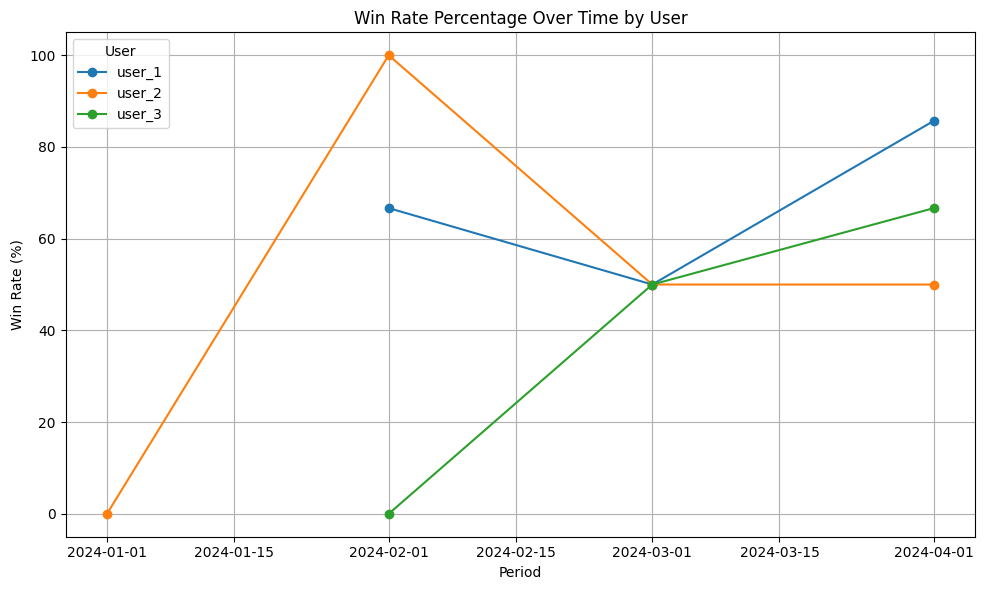

In [21]:

# Plotting win_rate_pct over time for each user
plt.figure(figsize=(10, 6))
for user in df['assigned_to'].unique():
    subset = df[df['assigned_to'] == user]
    plt.plot(subset['period'], subset['win_rate_pct'], marker='o', label=user)

plt.title('Win Rate Percentage Over Time by User')
plt.xlabel('Period')
plt.ylabel('Win Rate (%)')
plt.legend(title='User')
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
conn.close()